## Check purchase_amount rate per month_lag
<br/>
month_lag 를 1달 기준을 purchase_amount의 mean, sum, size 변화량의 평균, 편차를 계산<br/>
target과 관계 확인<br/>
<br/>

In [1]:
import os
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc

In [2]:
input_dir = os.path.join('..', 'input')
file_csv = [file for file in os.listdir(input_dir)\
            if file.endswith('.csv')]
print(file_csv)

['historical_transactions.csv', 'merchants.csv', 'new_merchant_transactions.csv', 'sample_submission.csv', 'train.csv', 'test.csv']


In [3]:
pd.set_option('max_columns', None)

In [4]:
## Pandas@reduce dataframe memory
def reduce_mem_usage(props, fillna=False, fillval=None):
    start_mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ", col)
            print("dtype before: ", props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                if not fillna:
                    print('[*]skip {} cause of NA value'.format(col))
                    continue
                NAlist.append(col)
                props[col].fillna(fillval,inplace=True)  
            
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < pow(2, 8)-1:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < pow(2, 16)-1:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < pow(2, 32)-1:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [5]:
trans_df = pd.read_csv(os.path.join(input_dir, 'historical_transactions.csv'))
train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
trans_df, _ = reduce_mem_usage(trans_df, fillna=False, fillval=-999)
train_df, _ = reduce_mem_usage(train_df, fillna=False, fillval=-999)

Memory usage of properties dataframe is : 3109.5357055664062  MB
******************************
Column:  city_id
dtype before:  int64
dtype after:  int16
******************************
******************************
Column:  installments
dtype before:  int64
dtype after:  int16
******************************
******************************
Column:  merchant_category_id
dtype before:  int64
dtype after:  int16
******************************
******************************
Column:  month_lag
dtype before:  int64
dtype after:  int8
******************************
******************************
Column:  purchase_amount
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  category_2
dtype before:  float64
[*]skip category_2 cause of NA value
******************************
Column:  state_id
dtype before:  int64
dtype after:  int8
******************************
******************************
Column:  subsector_id
dtype before:  int64

In [6]:
trans_df = pd.merge(trans_df, train_df, on=['card_id'], how='left')

In [7]:
del train_df

In [8]:
trans_df = trans_df[trans_df['authorized_flag']=='Y'][['card_id', 'purchase_date', 'purchase_amount', 'first_active_month', 'month_lag', 'target']]
print('[*]trans_df : {}'.format(trans_df.shape))

[*]trans_df : (26595452, 6)


In [9]:
trans_df = trans_df[~trans_df.target.isnull()]

In [10]:
print('[*]trans_df : {}'.format(trans_df.shape))

[*]trans_df : (16468145, 6)


In [11]:
trans_df['purchase_year'] = trans_df['purchase_date'].apply(lambda x: x[0:4])
trans_df['purchase_month'] = trans_df['purchase_date'].apply(lambda x: x[5:7])

In [12]:
trans_df['purchase_year'] = trans_df['purchase_year'].astype(int)
trans_df['purchase_month'] = trans_df['purchase_month'].astype(int)
trans_df['month_lag'] = trans_df['month_lag'].astype(int)

In [13]:
trans_df.head(3)

,card_id,purchase_date,purchase_amount,first_active_month,month_lag,target,purchase_year,purchase_month
401,C_ID_5037ff576e,2017-08-14 15:46:08,1.189469,2017-01,-4,-2.352713,2017,8
402,C_ID_5037ff576e,2017-03-05 14:57:51,-0.640069,2017-01,-9,-2.352713,2017,3
403,C_ID_5037ff576e,2017-08-15 10:45:28,-0.652256,2017-01,-4,-2.352713,2017,8


In [14]:
trans_df['new_purchase_month'] = trans_df['purchase_month'] - trans_df['month_lag']
trans_df['new_purchase_year'] = trans_df['purchase_year']

In [15]:
over_month_idx = trans_df[trans_df['new_purchase_month']>12].index.values

In [16]:
trans_df.loc[over_month_idx,'new_purchase_month'] = trans_df.loc[over_month_idx,'new_purchase_month'] - 12
trans_df.loc[over_month_idx,'new_purchase_year'] = trans_df.loc[over_month_idx,'purchase_year'] + 1

In [17]:
print('unique count -> new_purchase_month : {}'.format(max(trans_df.groupby(['card_id']).new_purchase_month.nunique())))
print('unique count -> new_purchase_year : {}'.format(max(trans_df.groupby(['card_id']).new_purchase_year.nunique())))

unique count -> new_purchase_month : 1
unique count -> new_purchase_year : 1


In [18]:
trans_df['first_active_year'] = trans_df['first_active_month'].apply(lambda x: x[0:4])
trans_df['first_active_month'] = trans_df['first_active_month'].apply(lambda x: x[5:])

In [19]:
print('unique count -> first_active_year : {}'.format(max(trans_df.groupby(['card_id']).first_active_year.nunique())))
print('unique count -> first_active_month : {}'.format(max(trans_df.groupby(['card_id']).first_active_month.nunique())))

unique count -> first_active_year : 1
unique count -> first_active_month : 1


In [20]:
trans_df.head(3)

,card_id,purchase_date,purchase_amount,first_active_month,month_lag,target,purchase_year,purchase_month,new_purchase_month,new_purchase_year,first_active_year
401,C_ID_5037ff576e,2017-08-14 15:46:08,1.189469,01,-4,-2.352713,2017,8,12,2017,2017
402,C_ID_5037ff576e,2017-03-05 14:57:51,-0.640069,01,-9,-2.352713,2017,3,12,2017,2017
403,C_ID_5037ff576e,2017-08-15 10:45:28,-0.652256,01,-4,-2.352713,2017,8,12,2017,2017


In [98]:
lag_features = trans_df.groupby(['card_id', 'month_lag']).aggregate({'purchase_amount':['size', 'mean', 'sum']}).unstack()
lag_features.head(3)

purchase_amount                                              \
                           size                                               
month_lag                   -13  -12  -11  -10  -9    -8    -7    -6    -5    
card_id                                                                       
C_ID_00007093c1             NaN  4.0  7.0  9.0  6.0  13.0  13.0  14.0   4.0   
C_ID_0001506ef0             2.0  5.0  8.0  NaN  1.0   2.0   2.0   2.0   2.0   
C_ID_000183fdda             NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN  22.0   

                                                                           \
                                                 mean                       
month_lag         -4   -3    -2    -1     0       -13       -12       -11   
card_id                                                                     
C_ID_00007093c1  12.0  5.0  11.0   8.0   8.0      NaN -0.333604 -0.560815   
C_ID_0001506ef0   3.0  7.0  17.0   7.0   4.0 -0.70859 -0.691466 -0.693088   
C_ID_000183fdda  24.0  9.0  26.0  28.0  28.0      NaN       NaN       NaN   

                                                                            \
                                                                             
month_lag             -10       -9        -8       -7        -6        -5    
card_id                                                                      
C_ID_00007093c1 -0.546012 -0.574854 -0.577617 -0.61782 -0.471708 -0.556233   
C_ID_0001506ef0       NaN -0.701828 -0.731430  0.01719 -0.108657 -0.168011   
C_ID_000183fdda       NaN       NaN       NaN      NaN       NaN -0.632501   

                                                                            \
                                                                       sum   
month_lag             -4        -3        -2        -1         0       -13   
card_id                                                                      
C_ID_00007093c1 -0.627612 -0.499872 -0.530359 -0.570987 -0.502207      NaN   
C_ID_0001506ef0 -0.290733 -0.513078 -0.607728 -0.453826 -0.155333 -1.41718   
C_ID_000183fdda -0.602618 -0.373307 -0.497646 -0.270757 -0.558534      NaN   

                                                                             \
                                                                              
month_lag             -12       -11       -10       -9        -8        -7    
card_id                                                                       
C_ID_00007093c1 -1.334414 -3.925706 -4.914105 -3.449126 -7.509018 -8.031655   
C_ID_0001506ef0 -3.457330 -5.544708       NaN -0.701828 -1.462861  0.034381   
C_ID_000183fdda       NaN       NaN       NaN       NaN       NaN       NaN   

                                                                      \
                                                                       
month_lag             -6         -5         -4        -3         -2    
card_id                                                                
C_ID_00007093c1 -6.603911  -2.224931  -7.531348 -2.499360  -5.833953   
C_ID_0001506ef0 -0.217313  -0.336023  -0.872199 -3.591547 -10.331373   
C_ID_000183fdda       NaN -13.915015 -14.462822 -3.359763 -12.938804   

                                      
                                      
month_lag             -1          0   
card_id                               
C_ID_00007093c1 -4.567894  -4.017653  
C_ID_0001506ef0 -3.176785  -0.621331  
C_ID_000183fdda -7.581191 -15.638963

In [99]:
new_cols = []
for x in lag_features.columns:
    new_cols.append('_'.join([str(a) for a in x]))
lag_features.columns = new_cols

In [100]:
lag_features.fillna(0, inplace=True)

In [101]:
lag_features = pd.merge(lag_features, trans_df[['card_id', 'target']], on=['card_id'], how='left')
lag_features = lag_features.drop_duplicates()

In [102]:
lag_features.head(3)

,card_id,purchase_amount_size_-13,purchase_amount_size_-12,purchase_amount_size_-11,purchase_amount_size_-10,purchase_amount_size_-9,purchase_amount_size_-8,purchase_amount_size_-7,purchase_amount_size_-6,purchase_amount_size_-5,purchase_amount_size_-4,purchase_amount_size_-3,purchase_amount_size_-2,purchase_amount_size_-1,purchase_amount_size_0,purchase_amount_mean_-13,purchase_amount_mean_-12,purchase_amount_mean_-11,purchase_amount_mean_-10,purchase_amount_mean_-9,purchase_amount_mean_-8,purchase_amount_mean_-7,purchase_amount_mean_-6,purchase_amount_mean_-5,purchase_amount_mean_-4,purchase_amount_mean_-3,purchase_amount_mean_-2,purchase_amount_mean_-1,purchase_amount_mean_0,purchase_amount_sum_-13,purchase_amount_sum_-12,purchase_amount_sum_-11,purchase_amount_sum_-10,purchase_amount_sum_-9,purchase_amount_sum_-8,purchase_amount_sum_-7,purchase_amount_sum_-6,purchase_amount_sum_-5,purchase_amount_sum_-4,purchase_amount_sum_-3,purchase_amount_sum_-2,purchase_amount_sum_-1,purchase_amount_sum_0,target
0,C_ID_00007093c1,0.0,4.0,7.0,9.0,6.0,13.0,13.0,14.0,4.0,12.0,5.0,11.0,8.0,8.0,0.00000,-0.333604,-0.560815,-0.546012,-0.574854,-0.577617,-0.61782,-0.471708,-0.556233,-0.627612,-0.499872,-0.530359,-0.570987,-0.502207,0.00000,-1.334414,-3.925706,-4.914105,-3.449126,-7.509018,-8.031655,-6.603911,-2.224931,-7.531348,-2.499360,-5.833953,-4.567894,-4.017653,0.134077
114,C_ID_0001506ef0,2.0,5.0,8.0,0.0,1.0,2.0,2.0,2.0,2.0,3.0,7.0,17.0,7.0,4.0,-0.70859,-0.691466,-0.693088,0.000000,-0.701828,-0.731430,0.01719,-0.108657,-0.168011,-0.290733,-0.513078,-0.607728,-0.453826,-0.155333,-1.41718,-3.457330,-5.544708,0.000000,-0.701828,-1.462861,0.034381,-0.217313,-0.336023,-0.872199,-3.591547,-10.331373,-3.176785,-0.621331,0.884295
176,C_ID_000183fdda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,24.0,9.0,26.0,28.0,28.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.632501,-0.602618,-0.373307,-0.497646,-0.270757,-0.558534,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.915015,-14.462822,-3.359763,-12.938804,-7.581191,-15.638963,-0.264433


In [103]:
rate_col_name = 'rate_{}_{}_{}'
month_mean_col_name = 'purchase_amount_{}_{}'

In [104]:
for col in ['size', 'mean', 'sum']:
    for month in range(0, -13, -1):
        before_col = month_mean_col_name.format(col, month)
        after_col = month_mean_col_name.format(col, month - 1)
        lag_features[rate_col_name.format(month, month-1, col)] = lag_features[after_col] / lag_features[before_col]

In [105]:
lag_features.head(3)

,card_id,purchase_amount_size_-13,purchase_amount_size_-12,purchase_amount_size_-11,purchase_amount_size_-10,purchase_amount_size_-9,purchase_amount_size_-8,purchase_amount_size_-7,purchase_amount_size_-6,purchase_amount_size_-5,purchase_amount_size_-4,purchase_amount_size_-3,purchase_amount_size_-2,purchase_amount_size_-1,purchase_amount_size_0,purchase_amount_mean_-13,purchase_amount_mean_-12,purchase_amount_mean_-11,purchase_amount_mean_-10,purchase_amount_mean_-9,purchase_amount_mean_-8,purchase_amount_mean_-7,purchase_amount_mean_-6,purchase_amount_mean_-5,purchase_amount_mean_-4,purchase_amount_mean_-3,purchase_amount_mean_-2,purchase_amount_mean_-1,purchase_amount_mean_0,purchase_amount_sum_-13,purchase_amount_sum_-12,purchase_amount_sum_-11,purchase_amount_sum_-10,purchase_amount_sum_-9,purchase_amount_sum_-8,purchase_amount_sum_-7,purchase_amount_sum_-6,purchase_amount_sum_-5,purchase_amount_sum_-4,purchase_amount_sum_-3,purchase_amount_sum_-2,purchase_amount_sum_-1,purchase_amount_sum_0,target,rate_0_-1_size,rate_-1_-2_size,rate_-2_-3_size,rate_-3_-4_size,rate_-4_-5_size,rate_-5_-6_size,rate_-6_-7_size,rate_-7_-8_size,rate_-8_-9_size,rate_-9_-10_size,rate_-10_-11_size,rate_-11_-12_size,rate_-12_-13_size,rate_0_-1_mean,rate_-1_-2_mean,rate_-2_-3_mean,rate_-3_-4_mean,rate_-4_-5_mean,rate_-5_-6_mean,rate_-6_-7_mean,rate_-7_-8_mean,rate_-8_-9_mean,rate_-9_-10_mean,rate_-10_-11_mean,rate_-11_-12_mean,rate_-12_-13_mean,rate_0_-1_sum,rate_-1_-2_sum,rate_-2_-3_sum,rate_-3_-4_sum,rate_-4_-5_sum,rate_-5_-6_sum,rate_-6_-7_sum,rate_-7_-8_sum,rate_-8_-9_sum,rate_-9_-10_sum,rate_-10_-11_sum,rate_-11_-12_sum,rate_-12_-13_sum
0,C_ID_00007093c1,0.0,4.0,7.0,9.0,6.0,13.0,13.0,14.0,4.0,12.0,5.0,11.0,8.0,8.0,0.00000,-0.333604,-0.560815,-0.546012,-0.574854,-0.577617,-0.61782,-0.471708,-0.556233,-0.627612,-0.499872,-0.530359,-0.570987,-0.502207,0.00000,-1.334414,-3.925706,-4.914105,-3.449126,-7.509018,-8.031655,-6.603911,-2.224931,-7.531348,-2.499360,-5.833953,-4.567894,-4.017653,0.134077,1.00,1.375000,0.454545,2.400000,0.333333,3.5,0.928571,1.0,0.461538,1.5,0.777778,0.571429,0.0,1.136956,0.928847,0.942515,1.255546,0.886268,0.848041,1.309750,0.934928,0.995217,0.949826,1.027112,0.594855,-0.000000,1.136956,1.277165,0.428416,3.013311,0.295423,2.968143,1.216197,0.934928,0.459331,1.424739,0.798865,0.339917,-0.000000
114,C_ID_0001506ef0,2.0,5.0,8.0,0.0,1.0,2.0,2.0,2.0,2.0,3.0,7.0,17.0,7.0,4.0,-0.70859,-0.691466,-0.693088,0.000000,-0.701828,-0.731430,0.01719,-0.108657,-0.168011,-0.290733,-0.513078,-0.607728,-0.453826,-0.155333,-1.41718,-3.457330,-5.544708,0.000000,-0.701828,-1.462861,0.034381,-0.217313,-0.336023,-0.872199,-3.591547,-10.331373,-3.176785,-0.621331,0.884295,1.75,2.428571,0.411765,0.428571,0.666667,1.0,1.000000,1.0,0.500000,0.0,inf,0.625000,0.4,2.921639,1.339120,0.844256,0.566645,0.577889,0.646722,-0.158208,-42.548931,0.959528,-0.000000,-inf,0.997659,1.024765,5.112868,3.252147,0.347635,0.242848,0.385259,0.646722,-0.158208,-42.548931,0.479764,-0.000000,-inf,0.623537,0.409906
176,C_ID_000183fdda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,24.0,9.0,26.0,28.0,28.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.632501,-0.602618,-0.373307,-0.497646,-0.270757,-0.558534,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.915015,-14.462822,-3.359763,-12.938804,-7.581191,-15.638963,-0.264433,1.00,0.928571,0.346154,2.666667,0.916667,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.484763,1.837982,0.750145,1.614268,1.049589,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.484763,1.706698,0.259666,4.304715,0.962123,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
size_cols = [x for x in lag_features.columns if 'size' in x]
mean_cols = [x for x in lag_features.columns if 'mean' in x]
std_cols = [x for x in lag_features.columns if 'sum' in x]

In [107]:
lag_features['rate_size_mean'] = lag_features[size_cols].apply(lambda x: np.mean([rate for rate in x if -100<=rate<=100]), axis=1)
lag_features['rate_size_std'] = lag_features[size_cols].apply(lambda x: np.std([rate for rate in x if -100<=rate<=100]), axis=1)
lag_features['rate_mean_mean'] = lag_features[mean_cols].apply(lambda x: np.mean([rate for rate in x if -100<=rate<=100]), axis=1)
lag_features['rate_mean_std'] = lag_features[mean_cols].apply(lambda x: np.std([rate for rate in x if -100<=rate<=100]), axis=1)
lag_features['rate_sum_mean'] = lag_features[std_cols].apply(lambda x: np.mean([rate for rate in x if -100<=rate<=100]), axis=1)
lag_features['rate_sum_std'] = lag_features[std_cols].apply(lambda x: np.std([rate for rate in x if -100<=rate<=100]), axis=1)

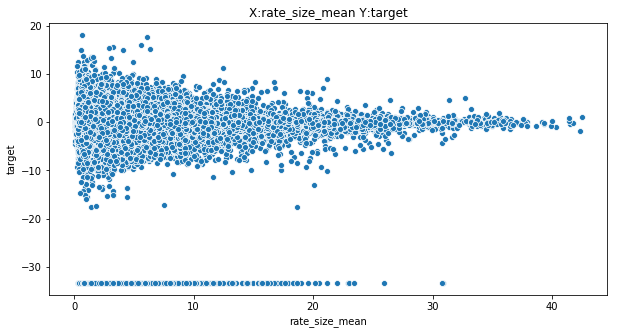

In [108]:
plt.figure(figsize=(10, 5))
plt.title('X:rate_size_mean Y:target')
sns.scatterplot(x='rate_size_mean', y='target', data=lag_features)

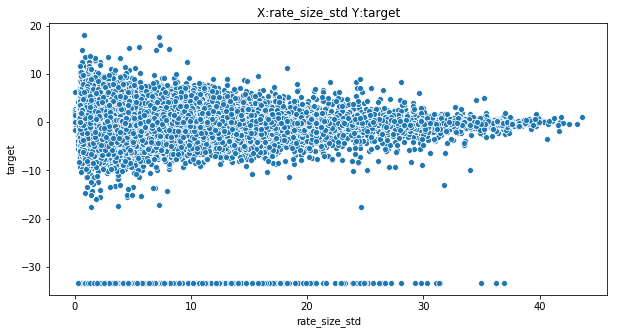

In [109]:
plt.figure(figsize=(10, 5))
plt.title('X:rate_size_std Y:target')
sns.scatterplot(x='rate_size_std', y='target', data=lag_features)

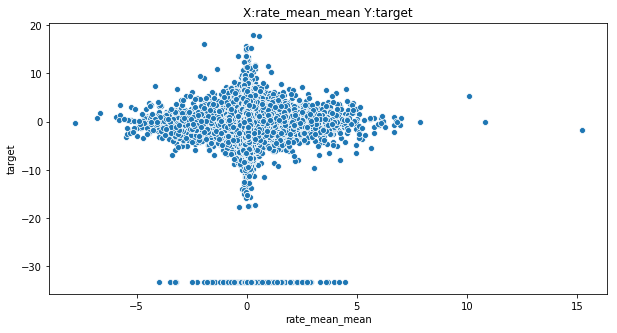

In [110]:
plt.figure(figsize=(10, 5))
plt.title('X:rate_mean_mean Y:target')
sns.scatterplot(x='rate_mean_mean', y='target', data=lag_features)

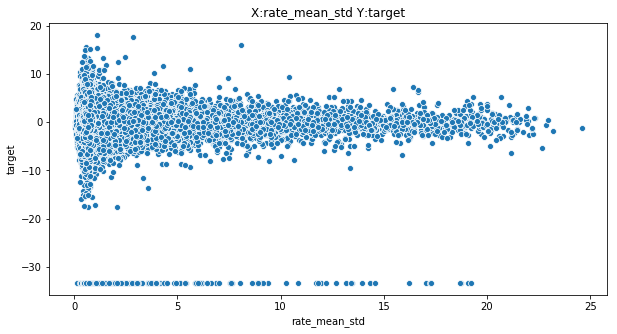

In [111]:
plt.figure(figsize=(10, 5))
plt.title('X:rate_mean_std Y:target')
sns.scatterplot(x='rate_mean_std', y='target', data=lag_features)

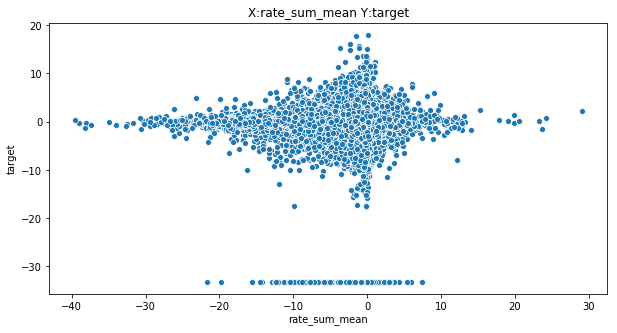

In [112]:
plt.figure(figsize=(10, 5))
plt.title('X:rate_sum_mean Y:target')
sns.scatterplot(x='rate_sum_mean', y='target', data=lag_features)

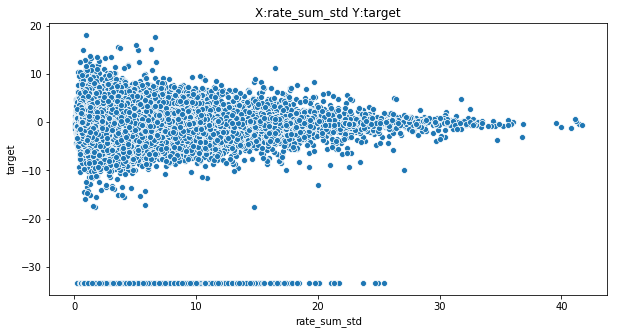

In [115]:
plt.figure(figsize=(10, 5))
plt.title('X:rate_sum_std Y:target')
sns.scatterplot(x='rate_sum_std', y='target', data=lag_features)